In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from ctrl_mult_mod import ctrl_mult_mod
from math import log2, pi

def semi_classical_QFT_inv(qc,q_reg,c_reg):
    """ Aplica a IQFT semi clássica
    
    qc : QuantumCircuit
        Circuito quântico para aplicar a IQFT
    q_reg : QuantumRegister
        Registrador quântico para a qft ser aplicada (será aplicada no 1o bit)
    c_reg : ClassicalRegister
        Registrador clássico para a medição dos qubits
    """
    try:
        n = q_reg.size
    except:
        n = len(q_reg)
    for i in range(n-1,-1,-1):
        for j in range(n-1,i,-1):
            with qc.if_test((c_reg[n-1-j],1)) as else_:
                qc.p((-pi/(2**(j-(i)))),q_reg[i])
            # with else_:
            #     pass
        qc.h(q_reg[i])
        qc.measure(q_reg[i],c_reg[n-1-i])


def semi_classical_QFT_inv_1_bit(qc, q_reg, c_reg, n):
    """ Aplica a IQFT semi clássica em um qubit
    
    qc : QuantumCircuit
        Circuito quântico para aplicar a IQFT
    q_reg : QuantumRegister
        Registrador quântico para a qft ser aplicada (será aplicada no 1o bit)
    c_reg : ClassicalRegister
        Registrador clássico para a medição dos qubits
    n : int
        Número de bits na IQFT original
    """

    for i in range(n-1,-1,-1):
        for j in range(n-1,i,-1):
            with qc.if_test((c_reg[n-1-j],1)) as else_:
                qc.p((-pi/(2**(j-(i)))), q_reg[0])
            # with else_:
            #     pass
        qc.h(q_reg[0])
        qc.measure(q_reg[0],c_reg[n-1-i])


def qft_rotations(circuit, n):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    if n == 0:
        return circuit
    n -= 1

    circuit.h(n)
    for qubit in range(n):
        if qubit >= 0:
            circuit.cp(pi/2**(n-qubit), qubit, n)
    # At the end of our function, we call the same function again on
    # the next qubits (we reduced n by one earlier in the function)
    qft_rotations(circuit, n)
    return circuit

def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

def qft(circuit, n, do_swaps=False):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    if do_swaps:
        swap_registers(circuit, n)
    return circuit

def gcdExtended(a, b): 
    # Base Case 
    if a == 0 : 
        return b,0,1
             
    gcd,x1,y1 = gcdExtended(b%a, a) 
     
    # Update x and y using results of recursive 
    # call 
    x = y1 - (b//a) * x1 
    y = x1 
     
    return gcd,x,y 

def mod_inverse(x, p):
    """Retorna o inverso modular x^-1 mod p"""
    gcd, inv, _ = gcdExtended(x, p)
    if gcd != 1:
        raise ValueError("O inverso não existe")
    return inv % p

In [2]:
def simbolo_de_jacobi(a, n):
    """
    a = numerador
    n = denominador
    """

    a %= n
    t = 1
    while a != 0:
        while a % 2 == 0:
            a /= 2
            r = n % 8
            if r == 3 or r == 5:
                t = -t
        a, n = n, a
        if a % 4 == 3 and n % 4 == 3:
            t = -t
        a %= n
    if n == 1:
        return t
    else:
        return 0



In [31]:
"""Valores:
    b*A^x mod N : x é o valor em superposição
    b é inicializado como 1.
    O valor da variável x_bits corresponde ao tamanho da amostra (2**x_bits).
"""

N = 15  # N = p*q; p, q primos
n_bits = int(log2(N))+1

bases = []
for i in range(1000):
    if simbolo_de_jacobi(i, N) == -1:
        bases.append(i)
print(bases)
A = bases[0] # Base do expoente

b = 1 # Registrador inicial da multiplicação

x_bits = n_bits # q=2**x_bits, tamanho da amostra, idealmente é 2n_bits

reg_x = QuantumRegister(1, "x")
#number_x = QuantumCircuit(reg_x)

reg_b = QuantumRegister(n_bits, "b")

# Registradores Ancillas
reg_0 = QuantumRegister(n_bits, "0")

reg_cout = QuantumRegister(1, "cout")

reg_help = QuantumRegister(1, "help")

reg_result = ClassicalRegister(x_bits, "resultado")


#x_bits + 2*n_bits + 3
expmod = QuantumCircuit(reg_x, reg_b, reg_0, reg_cout, reg_help, name="expmod")

qc = QuantumCircuit(reg_x, reg_b, reg_0, reg_cout, reg_help, reg_result)

qc.x(reg_b[0])

for i in range(x_bits-1,-1,-1):
    
    qc.h(reg_x[0])
    qc.append(ctrl_mult_mod(n_bits, (A**(2**(i))) % N, N), reg_x[:] + reg_b[:] + reg_0[:] + reg_cout[:] + reg_help[:])

    a_inv = mod_inverse(A**(2**i), N)

    qc.append(ctrl_mult_mod(n_bits, a_inv, N).inverse(), reg_x[:] + reg_0[:] + reg_b[:] + reg_cout[:] + reg_help[:])

    for j in range(n_bits):
        qc.cswap(reg_x[0], reg_b[j], reg_0[j])

    for j in range(x_bits-1,i,-1):
        with qc.if_test((reg_result[x_bits-1-j],1)) as else_:
            qc.p((-pi/(2**(j-(i)))), reg_x[0])
    qc.h(reg_x[0])
    qc.measure(reg_x[0], reg_result[x_bits-1-i])
    qc.reset(reg_x[0])


[7, 11, 13, 14, 22, 26, 28, 29, 37, 41, 43, 44, 52, 56, 58, 59, 67, 71, 73, 74, 82, 86, 88, 89, 97, 101, 103, 104, 112, 116, 118, 119, 127, 131, 133, 134, 142, 146, 148, 149, 157, 161, 163, 164, 172, 176, 178, 179, 187, 191, 193, 194, 202, 206, 208, 209, 217, 221, 223, 224, 232, 236, 238, 239, 247, 251, 253, 254, 262, 266, 268, 269, 277, 281, 283, 284, 292, 296, 298, 299, 307, 311, 313, 314, 322, 326, 328, 329, 337, 341, 343, 344, 352, 356, 358, 359, 367, 371, 373, 374, 382, 386, 388, 389, 397, 401, 403, 404, 412, 416, 418, 419, 427, 431, 433, 434, 442, 446, 448, 449, 457, 461, 463, 464, 472, 476, 478, 479, 487, 491, 493, 494, 502, 506, 508, 509, 517, 521, 523, 524, 532, 536, 538, 539, 547, 551, 553, 554, 562, 566, 568, 569, 577, 581, 583, 584, 592, 596, 598, 599, 607, 611, 613, 614, 622, 626, 628, 629, 637, 641, 643, 644, 652, 656, 658, 659, 667, 671, 673, 674, 682, 686, 688, 689, 697, 701, 703, 704, 712, 716, 718, 719, 727, 731, 733, 734, 742, 746, 748, 749, 757, 761, 763, 764, 772, 

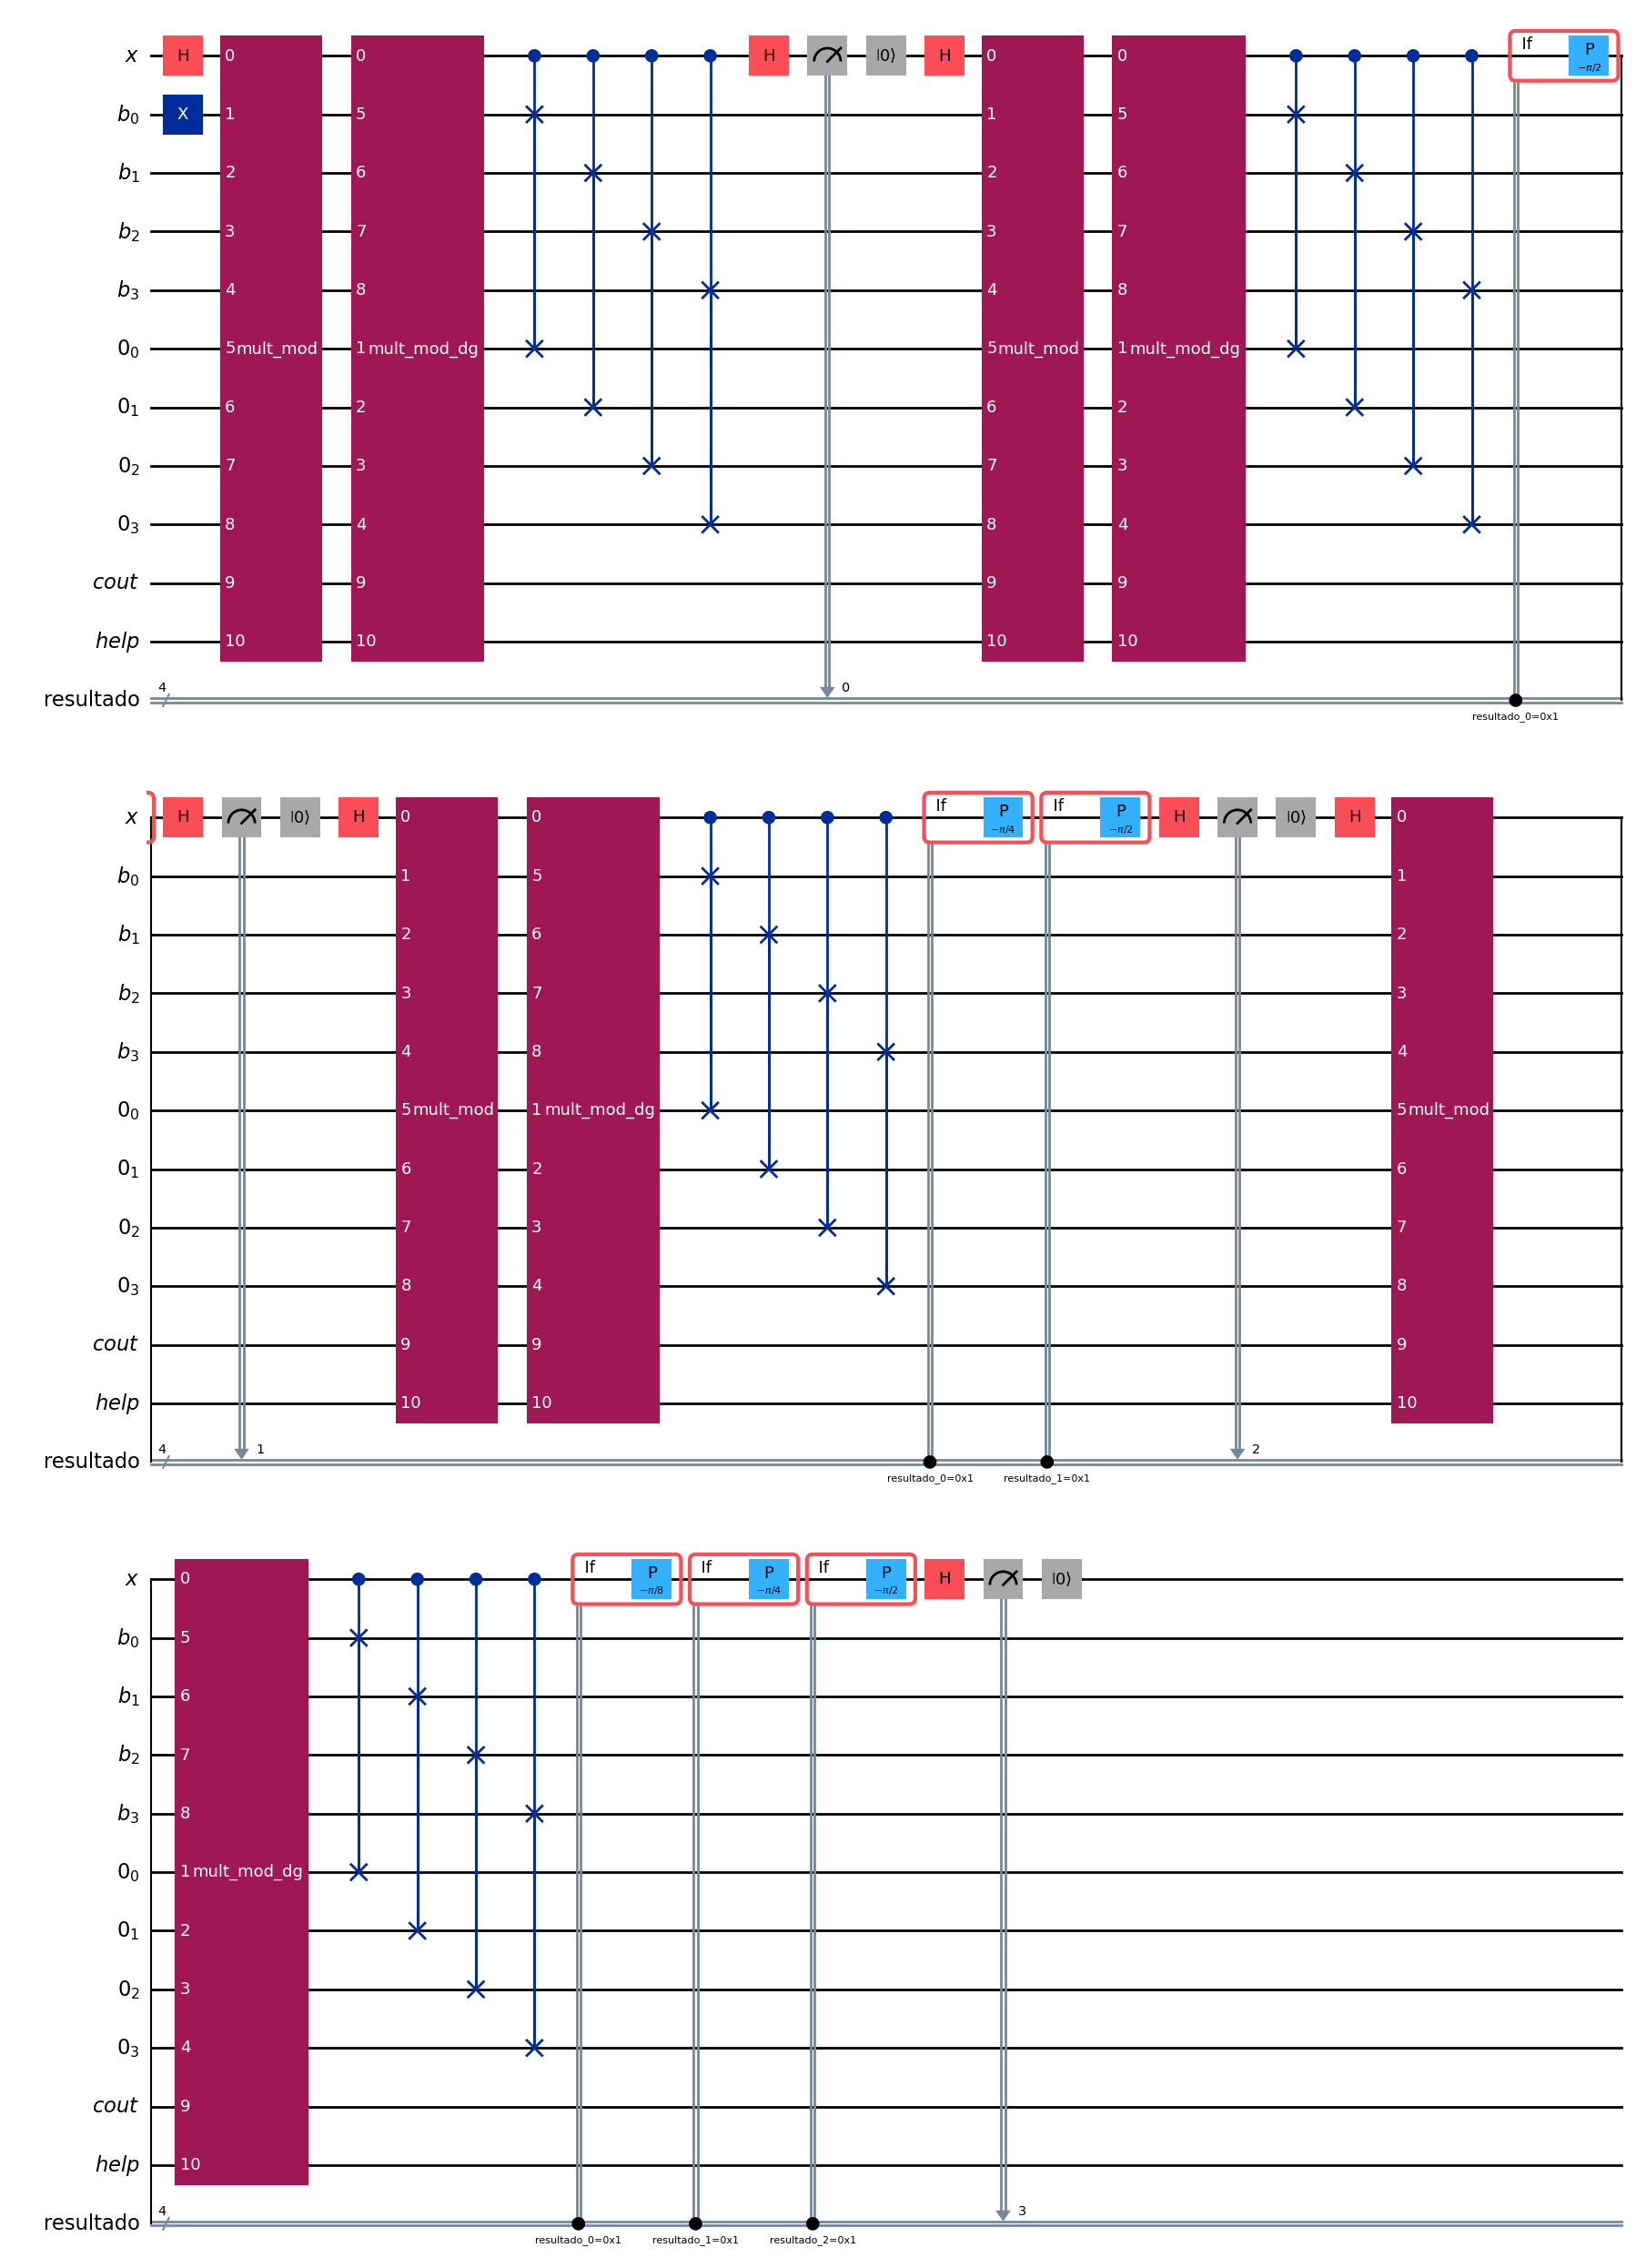

In [32]:
#expmod.draw("mpl")
qc.draw("mpl")

In [ ]:
"""
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit_ibm_runtime import SamplerV2 as Sampler

backend1 = AerSimulator(method="matrix_product_state")
qc1 = transpile(qc, backend=backend1)

sampler = Sampler(backend1)
job = sampler.run([qc1], shots=1024)
print("b=" + str(b), "A=" + str(A), "N=" + str(N))

counts = job.result()[0].data.resultado.get_int_counts()

print(counts)
"""

b=1 A=7 N=15
{4: 255, 12: 255, 8: 268, 0: 246}


In [ ]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(channel="ibm_quantum", token="")
brisbane = service.backend(name='ibm_brisbane')
pm = generate_preset_pass_manager(optimization_level=1, backend=brisbane)

In [35]:
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit import transpile

sampler = Sampler(brisbane)
qc2 = transpile(qc, backend=brisbane)
job = sampler.run([qc2], shots=100)
print(job.job_id())

d0thp10htw7g008pfmtg


In [ ]:
qc2.draw()

In [38]:
from qiskit_ibm_runtime import QiskitRuntimeService

# job_id = "d0tgtsk93rd0008ng2zg"
# job_id = "d0th11c4mb60008xe3tg"
# job_id = "d0thgqa4mb60008xe4g0"
job_id = "d0thp10htw7g008pfmtg"

service = QiskitRuntimeService(channel="ibm_quantum", token="275112b4155e215962ae60e4a934422bf0336e2d3023b34a0a785014129903a65550fee551410cf3f7f32eee4771568b480eef006ba0699046872d7c9100d7e1")
#service.backends(simulator=False, operational=True, dynamic_circuits=True)
job = service.job(job_id)
result = job.result()

print(result)
print(result[0].data.resultado.get_int_counts())

PrimitiveResult([SamplerPubResult(data=DataBin(resultado=BitArray(<shape=(), num_shots=100, num_bits=4>)), metadata={'circuit_metadata': {}})], metadata={'execution': {'execution_spans': ExecutionSpans([DoubleSliceSpan(<start='2025-05-27 01:53:40', stop='2025-05-27 01:59:10', size=100>)])}, 'version': 2})
{9: 6, 12: 7, 14: 6, 15: 9, 4: 7, 5: 8, 13: 4, 6: 5, 3: 7, 10: 5, 1: 7, 11: 4, 7: 9, 2: 7, 8: 4, 0: 5}


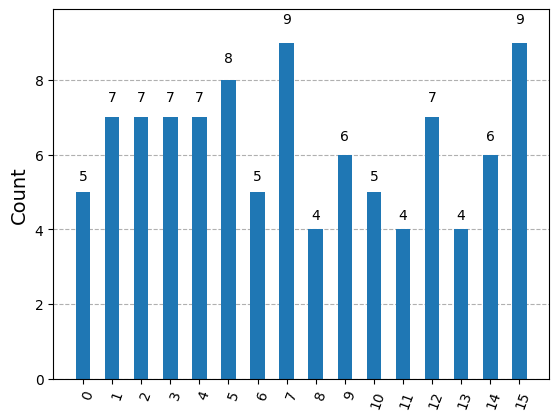

In [39]:
from qiskit.visualization import plot_histogram

plot_histogram(result[0].data.resultado.get_int_counts())

In [ ]:
lcounts = []

for i in counts:
    lcounts.append((i, counts[i]))

lcounts.sort(reverse=True, key=lambda x: x[1])
print(lcounts)

[(15292, 1), (1638, 1)]


In [ ]:
from math import gcd

def algoritmo_fracoes_continuas(a, b):
    """Calcula os termos de uma fração continuada do número a/b
    """

    if gcd(a,b) != 1:
        mdc = gcd(a,b)
        a = a//mdc
        b = b//mdc

    l = []

    if a < b:
        l.append(0)
        return l + algoritmo_fracoes_continuas(b, a)

    l.append(a//b)

    if b == 1:
        return l
    
    return l + algoritmo_fracoes_continuas(b, a % b)

def desfazer_fracoes_continuas(l, aproximacao):
    a, b = 1, l[len(l)-1-aproximacao]

    for i in range(len(l)-2-aproximacao, -1, -1):
        a, b = b, l[i]*b + a
    
    return b, a

r_possiveis = []
listafracs = []

for i in range(len(lcounts)):
    listaatual = []
    if lcounts[i][0] != 0:
        l = algoritmo_fracoes_continuas(lcounts[i][0], 2**x_bits)
        #print(str(lcounts[i][0]) + "/" + str(2**x_bits), l)
        listaatual.append(str(lcounts[i][0]) + "/" + str(2**x_bits))
        if l[0] != 0:
            for i in range(len(l)):
                listaatual.append(desfazer_fracoes_continuas(l, aproximacao=i))
                r_possiveis.append(val[1])
                listaatual.append(str(val[0]) + "/" + str(val[1]))
        else: 
            for i in range(1, len(l)-1):
                val = desfazer_fracoes_continuas(l, aproximacao=i)
                if val[1] < N and val[1] != 1:
                    r_possiveis.append(val[1])
                    listaatual.append(str(val[0]) + "/" + str(val[1]))
        listafracs.append(listaatual)

print(listafracs)
print(r_possiveis)

[['15292/16384', '14/15'], ['1638/16384', '1/10']]
[15, 10]


In [ ]:
def verificar_r(lista_r, bases, N):
    valores_obtidos = set()
    for base in bases:
      r_testados = set()
      for i in lista_r:
        if i < N and i not in r_testados:
          mdc = gcd(base**i - 1, N)
          if mdc != 1:
            valores_obtidos.add(mdc)
          r_testados.add(i)
    return valores_obtidos

print(verificar_r(r_possiveis, bases, N))

{11, 77, 7}


In [ ]:
Resultado = job.result()[0].data.resultado.get_int_counts()

for i in range(1<<(x_bits)):
  if i not in Resultado:
    Resultado[i] = 0

In [ ]:
from qiskit.visualization import plot_histogram

#plot_histogram(Resultado, figsize=[10,5])